In [187]:
# imports

import os
import subprocess
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

print("PyTorch version = {} ".format(torch.__version__))

PyTorch version = 0.4.0 


In [188]:
all_data = np.array([[-1.0000, 0.9517], 
[-0.9500, 0.9415],
[-0.9000, 0.8479],
[-0.8500, 0.7197],
[-0.8000, 0.6264],
[-0.7500, 0.5521],
[-0.7000, 0.4919],
[-0.6500, 0.4245],
[-0.6000, 0.3256],
[-0.5500, 0.2978],
[-0.5000, 0.2248],
[-0.4500, 0.2023],
[-0.4000, 0.1437],
[-0.3500, 0.0995],
[-0.3000, 0.1150],
[-0.2500, 0.1065],
[-0.2000, 0.0194],
[-0.1500, 0.0608],
[-0.1000, -0.0152],
[-0.0500, -0.0163],
[0.0000, -0.0396],
[0.0500, -0.0362],
[0.1000, 0.0555],
[0.1500, -0.0090],
[0.2000, 0.0701],
[0.2500, 0.0215],
[0.3000, 0.1188],
[0.3500, 0.1150],
[0.4000, 0.1250],
[0.4500, 0.2286],
[0.5000, 0.2816],
[0.5500, 0.2948],
[0.6000, 0.3446],
[0.6500, 0.3896],
[0.7000, 0.5351],
[0.7500, 0.5571],
[0.8000, 0.6113],
[0.8500, 0.7004],
[0.9000, 0.7618],
[0.9500, 0.8873],
[1.0000, 1.0165]])

np.random.shuffle(all_data)

train_x = all_data[0:31,0].reshape(1, -1).T
train_y = all_data[0:31,1].reshape(1, -1).T

valid_x = all_data[31:41,0].reshape(1, -1).T
valid_y = all_data[31:41,1].reshape(1, -1).T

In [189]:
# define hyperparams

class LRConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 epochs=3,
                 learning_rate=0.01,
                 momentum=0.1,
                 weight_decay=0.1,
                 architecture=[100, 3]):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.architecture = architecture
        self.weight_decay = weight_decay
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        status += "architecture = {}\n".format(self.architecture)
        status += "weight_decay = {}\n".format(self.weight_decay)

        return status

In [199]:
# set hyperparams

lr_config = LRConfig()
lr_config.epochs = 1000
lr_config.learning_rate = 0.1
lr_config.momentum = 0
lr_config.architecture = [5, 1]
lr_config.weight_decay = 0
print("Os hiper parâmetros do modelo de regressão logística são:\n")
print(lr_config)

Os hiper parâmetros do modelo de regressão logística são:

epochs = 1000
learning_rate = 0.1
momentum = 0
architecture = [5, 1]
weight_decay = 0



In [200]:
# organizing data

class DataHolder():
    """
    Class to store all data.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset):
                
        self.train_loader = DataLoader(dataset=train_dataset,
                                       batch_size=len(train_dataset),
                                       shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                       batch_size=len(valid_dataset))      

train_dataset = TensorDataset(torch.Tensor(train_x),
                              torch.Tensor(train_y))

valid_dataset = TensorDataset(torch.Tensor(valid_x),
                              torch.Tensor(valid_y))
self_driving_data = DataHolder(lr_config, train_dataset, valid_dataset) 

In [201]:
# define DFN model

class DFN(nn.Module):

    def __init__(self, config):
        super(DFN, self).__init__()
        self.classes = 1
        self.params = 1
        self.num_layers = len(config.architecture)
        p_in = self.params
        for step, layer in enumerate(config.architecture):
            p_out = layer
            self.add_module("lin"+str(step), nn.Linear(p_in, p_out))
            self.add_module("relu"+str(step), nn.Tanh())
            p_in = p_out
        self.add_module("softmax", nn.Softmax(1))


    def forward(self, x):
        """
        Computes forward pass

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(batch_size, number_of_features))
        :return: logits
        :rtype: torch.FloatTensor(shape=[batch_size, number_of_classes])
        """
        inn = x
        for i in range(self.num_layers):
            linear = getattr(self, "lin"+str(i))
            mid = linear(inn)
            relu = getattr(self, "relu"+str(i))
            out = relu(mid)
            inn = out
        logits = out
        return logits

    def predict(self, x):
        logits = self.forward(x)
        probs = self.softmax(logits)
        predictions = probs.argmax(dim=1)
        return predictions

In [202]:
# model trainer

def train_model_classification(model,
                                   config,
                                   dataholder,
                                   criterion, 
                                   optimizer):

    train_loader = dataholder.train_loader
    valid_loader = dataholder.valid_loader

    train_loss = []
    valid_loss = []
    for epoch in range(config.epochs):
        for step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels) 
                    
            loss.backward()
            optimizer.step()
            
            if step % 10 == 0:
                train_loss.append(float(loss))
            
                # Test on validation data
                (v_images, v_labels) = next(iter(valid_loader))
                v_pred = model(v_images)
                v_loss = criterion(v_pred, v_labels)
                valid_loss.append(float(v_loss))
                        
    # Plot
    x = np.arange(1, len(train_loss) + 1, 1)
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.plot(x, train_loss, label='Energia TT')
    ax.plot(x, valid_loss, label='Energia TV')
    ax.legend()
    plt.xlabel('época')
    plt.ylabel('energia')
    plt.title('Energia TT e TV (ii=5)')
    plt.grid(True)
    plt.show()
        



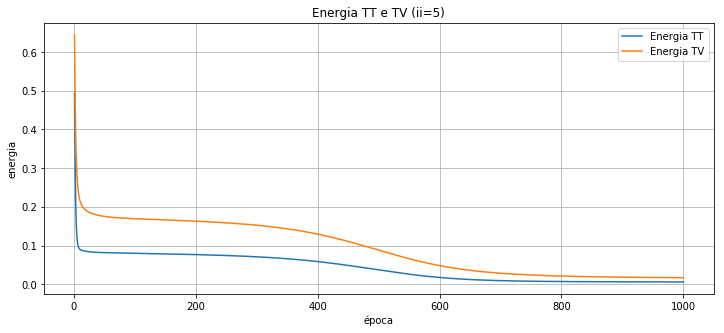

In [203]:
model = DFN(lr_config)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr_config.learning_rate, lr_config.momentum, weight_decay=lr_config.weight_decay)

train_model_classification(model,
                               lr_config,
                               self_driving_data,
                               criterion,
                               optimizer)